In [1]:
#| echo: false
#| output: false
%load_ext autoreload
%autoreload 2

::: {style="font-size: 50%;"}
## Consideraciones previas

- Se realizará una breve introducción a modelos de aprendizaje automático, pero se recomienda tener algún conocimiento previo para seguir el taller. 

- Durante el seminario se utilizarán los siguientes paquetes (**python**):

In [2]:
#| echo: true
#| code-fold: true
#| code-summary: "Imports"
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, to_rgb
from great_tables import GT, from_column, style, loc
from collections import Counter

# from sklearn import datasets
# Modelado
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    log_loss,
    recall_score,
    brier_score_loss,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from IPython.display import display, Markdown

# Funciones adicionales: 
from custom_functions import (
    plot_distribution,
    plot_calibration_models,
    plot_calibration,
    calibrate_model,
    calibration_table,
    calculate_clf_metrics,
)

import sklearn
sklearn.set_config(transform_output="pandas")

In [ ]:
#| echo: false
import matplotlib
import great_tables
from IPython.display import display, Markdown, Latex
Markdown(f"""
**Procesamiento de datos**:\n
📦 pandas=={pd.__version__}\n
📦 numpy=={np.__version__}\n
\n
**Modelado**:\n
📦 scikit-learn=={sklearn.__version__}\n
\n
**Visualización y tablas:**\n
📦 matplotlib=={matplotlib.__version__}\n
📦 seaborn=={sns.__version__}\n
📦 great_tables=={great_tables.__version__}\n
""")

In [3]:
#| echo: false
#| code-fold: false
color_verde = "#255255"
color_verde_claro = "#BDCBCC"

:::


# Introducción a machine learning

## Machine Learning

En general al hablar de machine learning se hace referencia a diversos tipos de modelos. En esta presentación se analizará el caso particular de los modelos de clasificación, haciendo énfasis en la estimación de probabilidad.

```{mermaid}
flowchart LR
    ml[Machine Learning]
    supervised[Aprendizaje <br> supervisado]
    unsupervised[Aprendizaje <br> no supervisado]
    semisupervised[Aprendizaje <br> semi supervizado]
    reinforce[Aprendizaje <br> por refuerzo]

    ml_clf[Modelos de <br>clasificación]
    ml_reg[Modelos de <br>regresión]
    ml_clfclass[Predicción de<br>clase]
    ml_clfprob[Predicción de <br>probabilidad]:::redclass

    ml-->supervised
    ml-->unsupervised
    ml-->semisupervised
    ml-->reinforce

    supervised-->ml_clf
    supervised-->ml_reg
    ml_clf-->ml_clfclass
    ml_clf-->ml_clfprob

    classDef redclass fill:#255255,stroke:#333,stroke-width:2px,color:white;
    classDef blueclass fill:#BDCBCC,stroke:#333,stroke-width:2px,color:white;
```


## ¿Qué es un modelo de clasificación binaria?
::: {style="font-size: 50%;"}

Se busca predecir la [probabilidad de ocurrencia]{style="color: blue"} de un evento a partir de ciertas características observables:

> $P(y=1) = f(X)$
>
> *Siendo y una variable que puede tomar 2 valores: 0 o 1*

::: {.fragment .fade-in}
<br> 
**Ejemplos de clasificación:**

▪️**Iris**: Clasificación de especies de plantas

▪️**Titanic**: Clasificación de individuos en sobrevivientes y no sobrevivientes

::: {.fragment .highlight-red}
▪️**German Credit**: Clasificación de individuos en riesgosos o no riesgosos
:::
:::
:::


# Caso: German Credit

## Datos

::: {style="font-size: 50%;"}

In [5]:
#| echo: true
#| code-fold: true
#| code-summary: "Código"
PATH_DATA = 'https://raw.githubusercontent.com/ayseceyda/german-credit-gini-analysis/master/gc.csv'
TARGET = "Risk"

df = (pd.read_csv(PATH_DATA)
  .drop('Unnamed: 0', axis=1)
  .assign(Risk = lambda x: np.where(x['Risk']=='good',0,1))
)

Se cuenta con un dataset de `{python} df.shape[0]` observaciones y `{python} df.shape[1]` variables.

In [6]:
#| echo: true
#| code-fold: true
#| code-summary: "Código"
#| tbl-cap: "Datos de German Credit (muestra de 6 observaciones)"
#| label: tbl-credit-data
def map_color(data):
    return (data[TARGET] == 1).map(
        {True: color_verde_claro, False: 'white'}
    )

(GT(df.sample(6, random_state=123)
        .set_index(TARGET)
        .reset_index()
    )
    .fmt_currency(columns="Credit amount")
    .tab_style(
        style=style.fill(color=map_color), locations=loc.body(columns=df.columns.tolist()),
    )
    .tab_style(
        style=style.text(color='red', weight = "bold"), locations=loc.body(TARGET),
    )
    .tab_options(
        column_labels_background_color=color_verde,
        table_font_names="Times New Roman"
    )
)

Risk,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
1,29,male,2,own,little,little,"$6,887.00",36,education
1,21,male,2,rent,little,little,$902.00,12,education
0,29,male,1,own,,moderate,"$2,333.00",24,furniture/equipment
1,20,female,2,rent,little,little,"$2,039.00",18,furniture/equipment
0,35,male,2,own,,moderate,"$2,728.00",15,radio/TV
0,23,male,2,own,,moderate,"$1,444.00",15,radio/TV


La variable objetivo (target) es Risk, donde el porcentaje de observaciones de clase 1 (riesgosos) es `{python} f"{df['Risk'].sum()/df.shape[0]:.1%}"`

:::

## Particiones
::: {style="font-size: 50%;"}

Partición en dataset de entrenamiento, validación y evaluación.

- Dataset de entrenamiento --> Ajuste del modelo
- Dataset de validación --> Calibración del modelo
- Dataset de evaluación --> Métricas del modelo calibrado

In [7]:
#| echo: true
#| code-fold: true
#| code-summary: "Código"
#| label: particiones
y = df[TARGET]
X = df.drop([TARGET], axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, shuffle=True, stratify=y, random_state=42
)

# Lo ideal es utilizar la partición de validación para calibración
X_valid, X_test, y_valid, y_test = train_test_split(
    X_test, y_test, test_size=0.5, shuffle=True, stratify=y_test, random_state=42
)

print(f"N observaciones en entrenamiento: {X_train.shape[0]}")
print(f"N observaciones en validación: {X_valid.shape[0]}")
print(f"N observaciones en evaluación: {X_test.shape[0]}")

N observaciones en entrenamiento: 500
N observaciones en validación: 250
N observaciones en evaluación: 250


::: 

# Modelo simple

::: {style="font-size: 50%;"}
## Modelo de clasificación simple

Se consideran 2 variables para ajustar un modelo de arbol de decisión con máxima profundidad=2

$$
P(\text{Risk}=1) = f(\text{Credit amount}, \text{Age})
$$

::: columns
::: {.column width="50%"}
::: {.fragment .fade-in}

In [8]:
#| echo: true
#| code-fold: true
#| code-summary: "Código"
#| tbl-cap: "Datos de German Credit (2 variables)"
#| label: tbl-credit-data-1var
subset_cols = ['Age', 'Credit amount']

(GT(pd.concat([y_train, X_train], axis=1)
        .sample(6, random_state=123)
        .set_index(TARGET)
        [subset_cols]
        .reset_index()
    )
    .fmt_currency(columns="Credit amount")
    .tab_style(
        style=style.fill(color=map_color), locations=loc.body(columns=df.columns.tolist()),
    )
    .tab_style(
        style=style.text(color='red', weight = "bold"), locations=loc.body(TARGET),
    )
    .tab_options(
        column_labels_background_color=color_verde,
        table_font_names="Times New Roman"
    )
)

Risk,Age,Credit amount
0,37,"$1,287.00"
1,27,"$8,648.00"
1,34,"$1,337.00"
0,48,"$2,134.00"
1,48,"$1,082.00"
0,53,"$2,424.00"


Ajuste del modelo:

In [9]:
#| echo: true
#| code-fold: true
#| code-summary: "Código"
X_train_subset = X_train[subset_cols].copy()
clf = DecisionTreeClassifier(max_depth=2).fit(X_train_subset, y_train)
clf

DecisionTreeClassifier(max_depth=2)

:::
:::

::: {.column width="50%"}
::: {.fragment .fade-in}

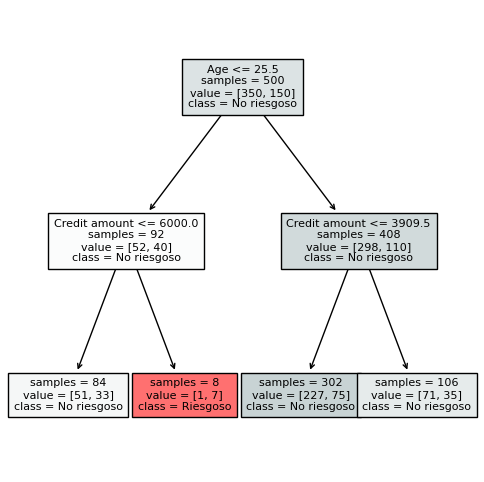

In [10]:
#| echo: true
#| code-fold: true
#| code-summary: "Código"
#| layout-align: center
#| fig-cap: "Modelo de árbol de decisión"
#| label: fig-credit-tree
colors = [color_verde, 'red']
labels = ['No riesgoso','Riesgoso']
plt.figure(figsize=(6,6))
arbol = plot_tree(
    clf,
    filled=True,
    impurity=False,
    feature_names=X_train_subset.columns.tolist(),
    class_names=labels,
    fontsize=8
)
for i, impurity, value in zip(arbol, clf.tree_.impurity, clf.tree_.value):
    # let the max value decide the color; whiten the color depending on impurity (gini)
    r, g, b = to_rgb(colors[np.argmax(value)])
    f = impurity * 2 # for N colors: f = impurity * N/(N-1) if N>1 else 0
    i.get_bbox_patch().set_facecolor((f + (1-f)*r, f + (1-f)*g, f + (1-f)*b))
    i.get_bbox_patch().set_edgecolor('black')
plt.show()

:::
:::
:::
:::

::: {style="font-size: 50%;"}
## Evaluación de un modelo de clasificación
::: columns
::: {.column width="50%"}
::: {.fragment .fade-in}
Se utiliza el método `clf.predict()`para predecir la clase (0,1) según el modelo (`clf`). A partir de la clase predicha se obtiene la matriz de confusión:

In [11]:
#| echo: true
#| code-fold: true
#| code-summary: "Ver código"
#| label: tbl-cm
#| tbl-cap: 'Matriz de confusión'
preds = pd.DataFrame({'Valor observado':y_test,'Valor predicho':clf.predict(X_test[subset_cols])})
display(GT(preds
    .groupby(['Valor observado','Valor predicho'], as_index=False).size()
    .pivot(index='Valor observado', columns='Valor predicho', values='size')
    .rename({0:'0',1:'1'}, axis=1)
    .reset_index()
    )
    .tab_spanner('Valor predicho', columns = ['0','1'])
    .data_color(
        columns=['0','1'],
        domain=[0,X.shape[0]],
        palette=[color_verde_claro, 'red'],
        na_color="white",
    )
)

GT(_tbl_data=Valor predicho  Valor observado    0  1
0                             0  172  3
1                             1   71  4, _body=<great_tables._gt_data.Body object at 0x16b6e3220>, _boxhead=Boxhead([ColInfo(var='Valor observado', type=<ColInfoTypeEnum.default: 1>, column_label='Valor observado', column_align='right', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='0', column_align='right', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='1', column_align='right', column_width=None)]), _stub=Stub([RowInfo(rownum_i=0, group_id=None, rowname=None, group_label=None, built=False), RowInfo(rownum_i=1, group_id=None, rowname=None, group_label=None, built=False)]), _row_groups=[], _group_rows=GroupRows([]), _spanners=Spanners([SpannerInfo(spanner_id='Valor predicho', spanner_level=0, spanner_label='Valor predicho', spanner_units=None, spanner_pattern=None, vars=['0', '1'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _source_notes=[], _footnotes=[], _styles=[StyleInfo(locname='data', locnum=5, grpname=None, colname='0', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#c8a8a9')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='0', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#c2bdbe')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='1', rownum=0, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#bdcacb')]), StyleInfo(locname='data', locnum=5, grpname=None, colname='1', rownum=1, colnum=None, styles=[CellStyleText(color='#000000', font=None, size=None, align=None, v_align=None, style=None, weight=None, stretch=None, decorate=None, transform=None, whitespace=None), CellStyleFill(color='#bdcacb')])], _locale=<great_tables._gt_data.Locale object at 0x16b6ec520>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, c

:::
:::
::: {.column width="50%"}
::: {.fragment .fade-in}

Además de predecir una clase, sklearn permite predecir una "probabilidad" con `clf.predict_proba()`:

In [12]:
#| echo: true
#| code-fold: true
#| code-summary: "Ver código"
#| label: tbl-predictproba
#| tbl-cap: 'clf.predict_proba(), muestra de 2 observaciones'
y_pred_proba = clf.predict_proba(X_test[subset_cols])[:, 1]
preds = pd.DataFrame({
    'y_obs':y_test,
    'predict_proba':y_pred_proba
})
GT(preds.sample(2, random_state=42)).fmt_number('predict_proba')

y_obs,predict_proba
0,0.25
1,0.33


In [13]:
metrica_auc = roc_auc_score(y_true=y_test, y_score=y_pred_proba)
metrica_logloss = log_loss(y_true=y_test, y_pred=y_pred_proba)
metrica_brierloss = brier_score_loss(y_true=y_test, y_prob=y_pred_proba)

print(f"""
ROC AUC = {metrica_auc:.2}, Log loss = {metrica_logloss:.2}, Brier loss = {metrica_brierloss:.2}
""")


ROC AUC = 0.64, Log loss = 0.59, Brier loss = 0.2



/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/envs/quarto-env/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


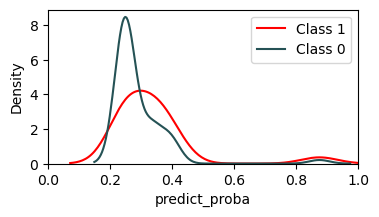

In [14]:
#| echo: true
#| code-fold: true
#| code-summary: "Ver código"
#| label: fig-distrib-tree
#| fig-cap: 'Distribución de "probabilidad" predicha'
distrib=plot_distribution(data=preds, pred_column='predict_proba', class_0_color=color_verde)
distrib

:::
:::
:::
:::

# Modelos más complejos

::: {style="font-size: 50%;"}
## Preprocesamiento

Se construye un pipeline de preprocesamiento de variables, diferenciando el procesamiento según tipo de datos: 

- Variables categóricas
- Variables numéricas

<br>

In [15]:
#| echo: true
#| code-fold: true
#| code-summary: "Ver código"
numeric_transformer = Pipeline([
    ('impute', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline([
    ('ohe',OneHotEncoder(
        min_frequency=0.05,
        handle_unknown='infrequent_if_exist',
        sparse_output=False)
    )
])

preproc = ColumnTransformer([
    ('num', numeric_transformer,
      make_column_selector(dtype_include=['float','int'])),
    ('cat', categorical_transformer,
      make_column_selector(dtype_include=['object','category']))
], verbose_feature_names_out=False)

In [16]:
#| echo: false
#| code-fold: false
#| classes: custom_class_html_display
#| layout-align: center
preproc

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('impute',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', MinMaxScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4310>),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                min_frequency=0.05,
                                                                sparse_output=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4910>)],
                  verbose_feature_names_out=False)

In [17]:
#| echo: true
#| code-fold: true
#| code-summary: "Código"
#| tbl-cap: "Datos de German Credit preprocesados (muestra de 2 observaciones)"
#| label: tbl-credit-data-preproc
display(GT(preproc.fit_transform(X_train).sample(2).round(2))
    .tab_options(
        column_labels_background_color=color_verde,
        table_font_names="Times New Roman"
    )
)

Age,Job,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Saving accounts_little,Saving accounts_moderate,Saving accounts_quite rich,Saving accounts_rich,Saving accounts_nan,Checking account_little,Checking account_moderate,Checking account_rich,Checking account_nan,Purpose_business,Purpose_car,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_infrequent_sklearn
0.45,0.67,0.37,0.36,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
0.48,0.33,0.24,0.2,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


::: 


## Modelado
::: {style="font-size: 50%;"}

Se ajustan distintos tipos de modelos reutilizando el mismo `pipeline` de preprocesamiento de datos:

In [18]:
def gen_pipe(model):
    pipe = Pipeline([
        ('preproc', preproc),
        ('model',model)
    ])
    return pipe

pipe_hist = gen_pipe(
    model = HistGradientBoostingClassifier(
        max_depth=4,
        learning_rate=0.1,
        max_iter=1000,
        random_state=42,
    )
)
pipe_hist_balanced = gen_pipe(
    model = HistGradientBoostingClassifier(
        max_depth=4,
        learning_rate=0.1,
        max_iter=1000,
        random_state=42,
        class_weight='balanced'
    )
)

pipe_tree = gen_pipe(
    model = DecisionTreeClassifier(random_state=42)
)
pipe_tree = gen_pipe(
    model = DecisionTreeClassifier(random_state=42)
)
pipe_reglog = gen_pipe(
    model = LogisticRegression(random_state=42)
)
pipe_reglog_balanced = gen_pipe(
    model = LogisticRegression(random_state=42, class_weight='balanced')
)
pipe_svc = gen_pipe(model = SVC(random_state=42, probability=True))

models_dict = {
    'Hist gradient boosting': pipe_hist,
    'Decision tree': pipe_tree,
    'Logistc regression': pipe_reglog,
    'SVC': pipe_svc,
    'Logistc regression (balanced)': pipe_reglog_balanced,
    'Hist gradient boosting (balanced)': pipe_hist_balanced
}

::: {.nav-pills}
::: {.panel-tabset}

In [19]:
# | output: asis
for i in models_dict.keys():
    display(Markdown(f"## {i}"))
    models_dict.get(i).fit(X_train, y_train)
    display(models_dict.get(i))
    display(Markdown(f" "))

## Hist gradient boosting

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4310>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4910>)],
                                   verbose_feature_names_out=False)),
                ('model',
                 HistGradientBoostingClassifier(max_depth=4, max_iter=1000,
                                                random_state=42))])

## Decision tree

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4310>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4910>)],
                                   verbose_feature_names_out=False)),
                ('model', DecisionTreeClassifier(random_state=42))])

## Logistc regression

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4310>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4910>)],
                                   verbose_feature_names_out=False)),
                ('model', LogisticRegression(random_state=42))])

## SVC

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4310>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4910>)],
                                   verbose_feature_names_out=False)),
                ('model', SVC(probability=True, random_state=42))])

## Logistc regression (balanced)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4310>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4910>)],
                                   verbose_feature_names_out=False)),
                ('model',
                 LogisticRegression(class_weight='balanced', random_state=42))])

## Hist gradient boosting (balanced)

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4310>),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                                 min_frequency=0.05,
                                                                                 sparse_output=False))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16bdf4910>)],
                                   verbose_feature_names_out=False)),
                ('model',
                 HistGradientBoostingClassifier(class_weight='balanced',
                                                max_depth=4, max_iter=1000,
                                                random_state=42))])

:::
:::
:::

::: {style="font-size: 50%;"}
## Evaluación

Se calculan las métricas de cada uno de los modelos:

In [20]:
#| tbl-cap: "Métricas de los modelos en la partición de evaluación"
#| label: tbl-metrics-uncalibrated
metrics_df = pd.DataFrame()
for i in models_dict.keys():
    pipe = models_dict.get(i)
    preds = pd.DataFrame({
        'y_true': y_test,
        'y_pred': pipe.predict(X_test),
        'y_pred_prob': pipe.predict_proba(X_test)[:,1],
    })
    m = calculate_clf_metrics(
        preds['y_true'], preds['y_pred'], preds['y_pred_prob'], 
        name=i
    ).reset_index().rename({'index':'Modelo'},axis=1)
    metrics_df = pd.concat([metrics_df, m], axis=0)

(GT(metrics_df.round(2))
    .data_color(
        columns=['Accuracy','Precision','Recall','F1','ROC AUC'],
        palette=[color_verde_claro, color_verde]
    )
    .data_color(
        columns=['Log Loss','Brier Loss'], palette=['white', 'red']
    )
)

Modelo,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss,Brier Loss
Hist gradient boosting,0.72,0.53,0.53,0.53,0.74,0.93,0.22
Decision tree,0.69,0.49,0.47,0.48,0.63,11.1,0.31
Logistc regression,0.74,0.59,0.45,0.51,0.75,0.53,0.18
SVC,0.73,0.6,0.33,0.43,0.72,0.55,0.19
Logistc regression (balanced),0.64,0.44,0.69,0.54,0.75,0.6,0.21
Hist gradient boosting (balanced),0.71,0.52,0.59,0.55,0.74,0.98,0.23


:::

::: {style="font-size: 50%;"}
## Problema

Planteo de problema organizacional

:::

# Calibración de probabilidades

::: {style="font-size: 50%;"}
## Calibración de probabilidades

**Objetivo:** 

Se busca encontrar una función que ajuste la relación entre los scores predichos por el modelo (predict_proba) y las probabilidades reales

> $P(y_i=1)= f(z)$
>
> Siendo: $P(y_{i}=1)$ la probabilidad calibrada para el individuo $i$ y $z_{i}$ el output del modelo no calibrado (score)

Un clasificador binario bien calibrado debería clasificar de forma tal que para las observaciones que predice un score (predict_proba) = 0.8, se espera que un 80% de las observaciones correspondan a la clase positiva (1).

**Referencias:**

- [Calibración de probabilidades en {scikit-learn} 📦 ](https://scikit-learn.org/stable/modules/calibration.html)

:::

::: {style="font-size: 50%;"}
## Calibración de probabilidades (Cont.)

::: {.fragment .fade-in}
**Métodos de calibración**

::: {.fragment .highlight-red}
 Calibración Sigmoide (Platt scaling)

 Calibración Isotónica
:::

 Calibración Beta (Nuevo)

 Calibración Spline (Nuevo)
:::
:::

::: {style="font-size: 50%;"}
## Calibración sigmoide (Platt scaling)

Este método asume una relación logística entre los scores (z) y la probabilidad real (p):

> $log(\frac{p}{1-p})=\alpha+\beta(z_{i})$ 
>
>
> $P(y_{i}=1) = \frac{1}{1+(e^{-(α+β(z_{i}))})}$
>
>
> Siendo: $y_{i}$ el valor observado para el individuo $i$ y $z_{i}$ el output del modelo no calibrado

<br>
Se estiman 2 parámetros ($\alpha$ y $\beta$), como en una regresión logística. 

- Requiere pocos datos

- Es útil cuando el modelo no calibrado tiene errores similares en predicción de valores bajos y altos 

<br>
**Referencias:**

- Platt, John. (2000). Probabilistic Outputs for Support Vector Machines and Comparisons to Regularized Likelihood Methods. Adv. Large Margin Classif, Volume 10 (pp. 61-74).

:::

::: {style="font-size: 50%;"}
## Calibración sigmoide (Platt scaling) (Cont.)

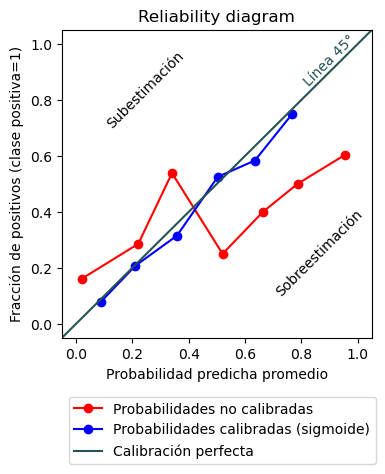

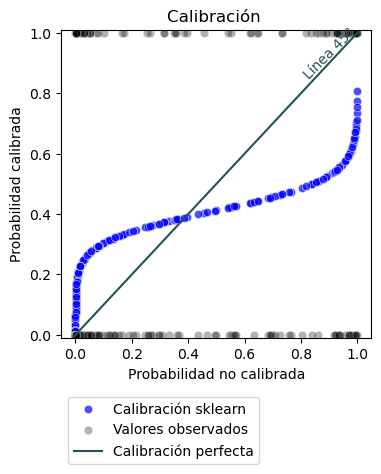

In [21]:
# | echo: true
# | eval: false
# | code-fold: true
# | code-summary: "Ver código"
pipe_sigmoid_hist, _, preds_hist = calibrate_model(
    pipe=pipe_hist,
    X_valid=X_valid, y_valid=y_valid, 
    X_test=X_test, y_test=y_test,
    cal_sigmoid=True,
    cal_isotonic=False,
    model_name=''
)
plot_calibration(
    preds=preds_hist,
    y_pred_prob_calibrated='pred_sigmoid',
    model_name=''
)

::: {.nav-pills}
::: {.panel-tabset}

## Hist gradient boosting

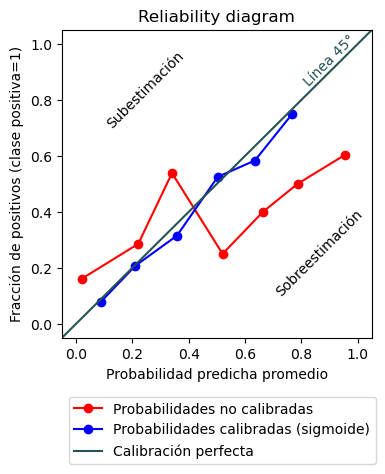

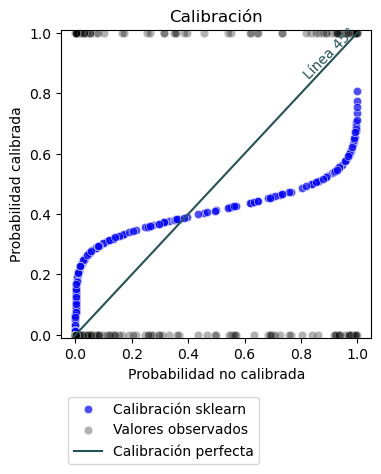

## Decision tree

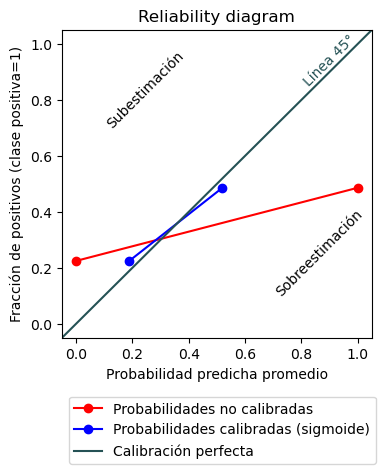

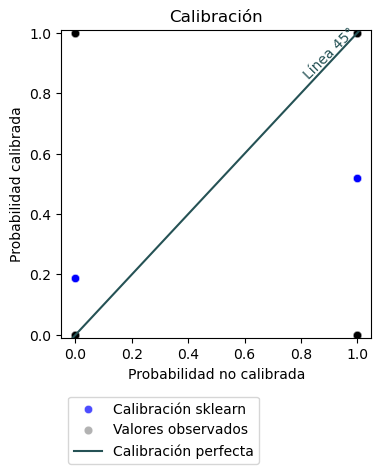

## Logistc regression

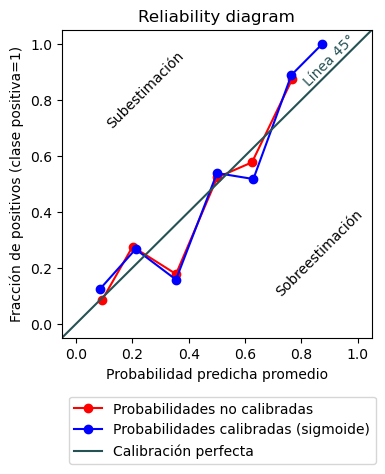

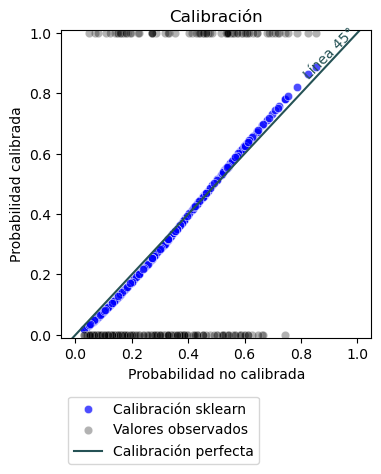

## SVC

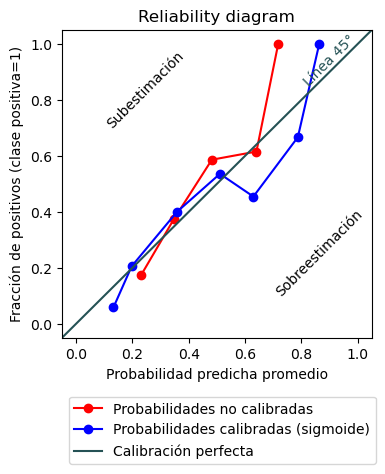

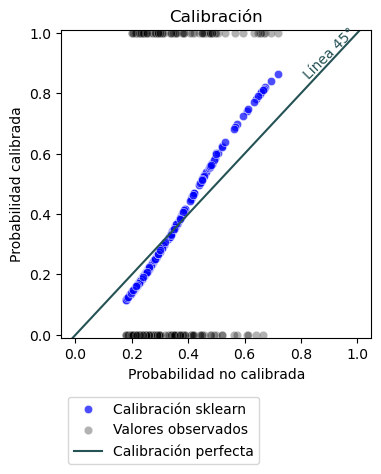

## Logistc regression (balanced)

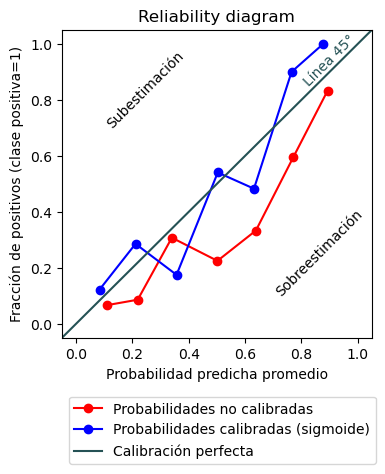

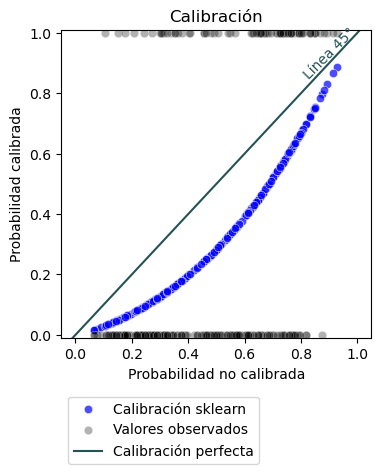

## Hist gradient boosting (balanced)

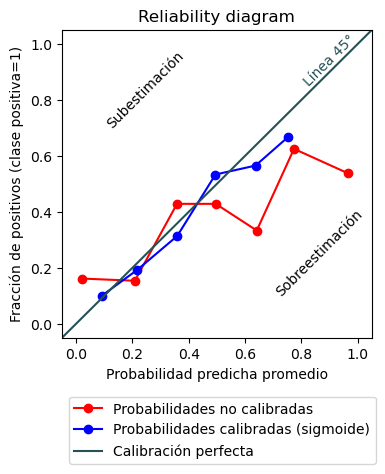

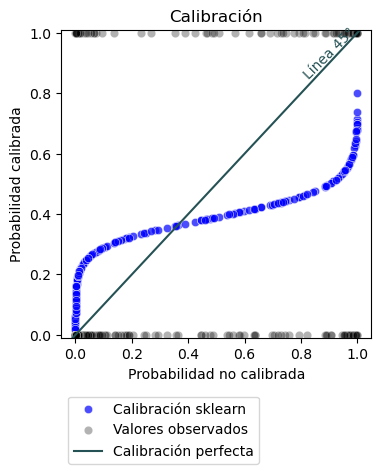

In [22]:
# | output: asis
for i in models_dict.keys():
    display(Markdown(f"## {i}"))

    # Curvas de calibración
    pipe_sigmoid, _, preds = calibrate_model(
        pipe=models_dict.get(i), 
        X_valid=X_valid, y_valid=y_valid, 
        X_test=X_test, y_test=y_test,
        cal_sigmoid=True,
        cal_isotonic=False,
        model_name=i
    )
    plt.show()

    # Calibración 
    plot_calibration(
        preds=preds,
        y_pred_prob_calibrated='pred_sigmoid',
        model_name=i
    )
    plt.title('Calibración')
    plt.show()

    display(Markdown(f" "))

:::
:::

In [ ]:
# Cálculo manual
# clf_log = LogisticRegression(random_state=42, C=0.1, solver="lbfgs")
# y_valid_pred_uncalibrated = pipe.predict_proba(X_valid)[:, 1]
# clf_log.fit(X=pd.DataFrame({"pred_prob": y_valid_pred_uncalibrated}), y=y_valid)

# preds["pred_sigmoid_manual"] = clf_log.predict_proba(preds[["pred_prob"]])[:, 1]

# Verificar por qué no funciona
# plt.figure()
# sns.scatterplot(
#     x="pred_prob",
#     y="pred_sigmoid_manual",
#     data=preds,
#     alpha=0.7,
#     label="Calibración manual",
# )

:::

::: {style="font-size: 50%;"}
## Calibración isotónica

Se ajusta un regresor isotónico no paramétrico, que produce una función escalonada no decreciente:

> $\sum_{i=1}^{n}(y_i - \hat{f_i})^2$
> 
> Sujeto a $\hat{f_i}$ >= $\hat{f_j}$ siempre $f_i$ > $f_j$ 
> $y_i$: etiqueta verdadera de la obseravción $i$ y sea la salida del clasificador calibrado para la muestra (es decir, la probabilidad calibrada)

In [ ]:
# print(f'% observado: {y_test.sum()/len(y_test):.3}')
# print(f'Prob promedio: {preds.pred_prob.mean():.3}')
# print(f'Prob promedio (calibración sigmoide): {prob_pos_sigmoid.mean():.3}')
# print(f'Prob promedio (calibración isotónica): {prob_pos_isotonic.mean():.3}')

:::

::: {style="font-size: 50%;"}
## Calibración isotónica (Cont.)

::: {.nav-pills}
::: {.panel-tabset}

## Hist gradient boosting

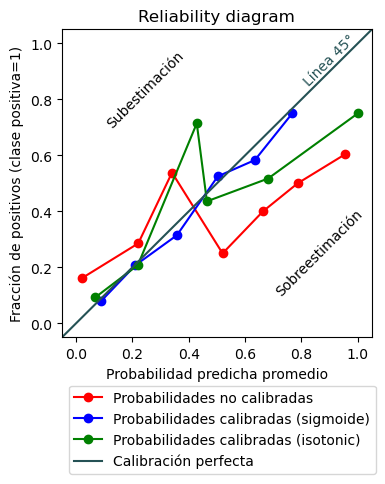

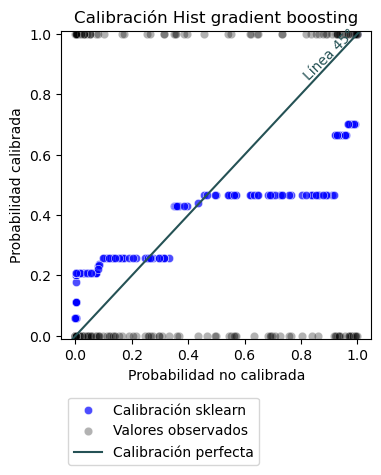

## Decision tree

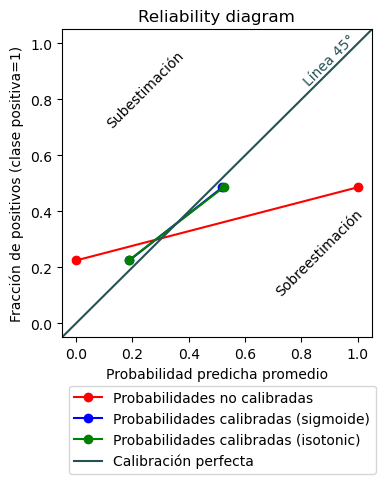

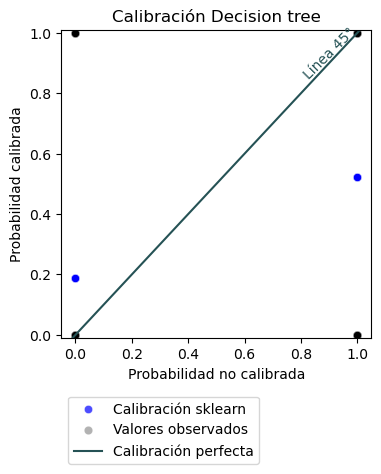

## Logistc regression

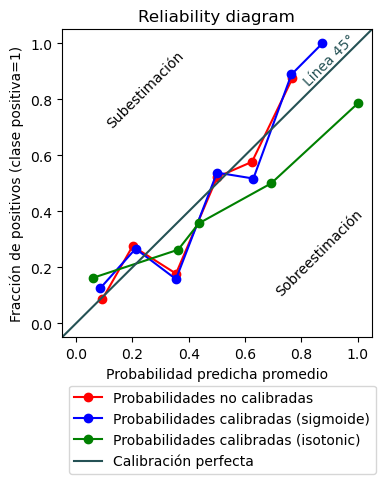

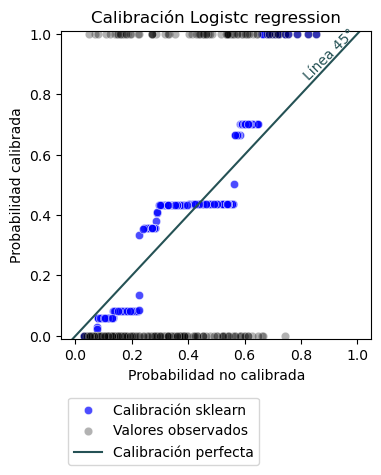

## SVC

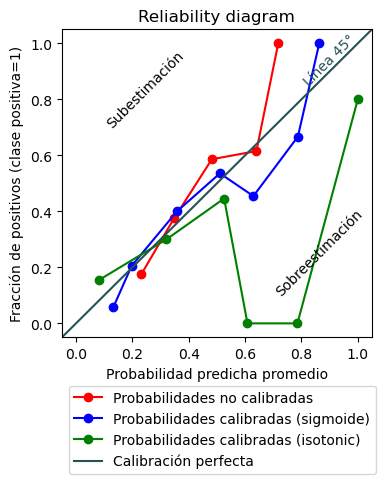

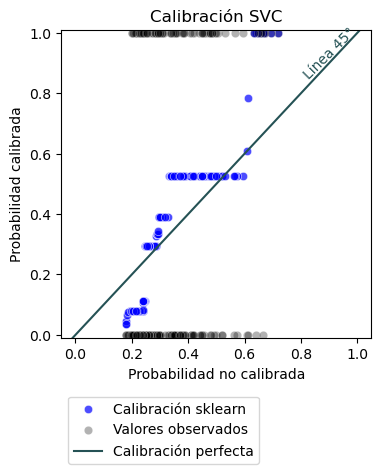

## Logistc regression (balanced)

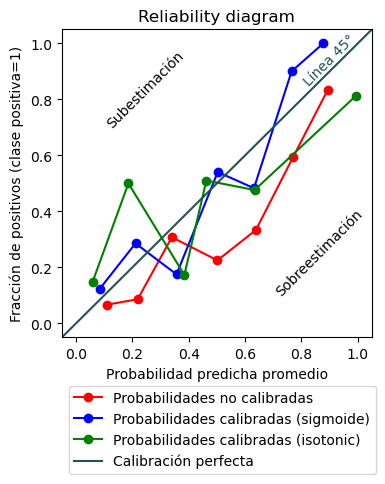

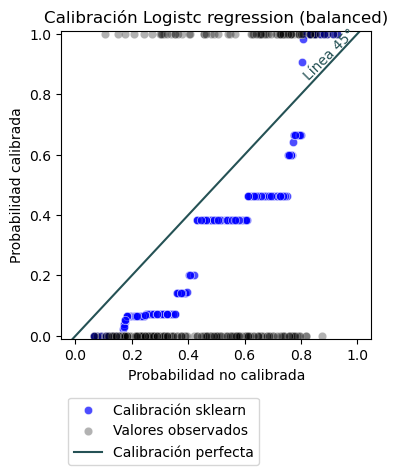

## Hist gradient boosting (balanced)

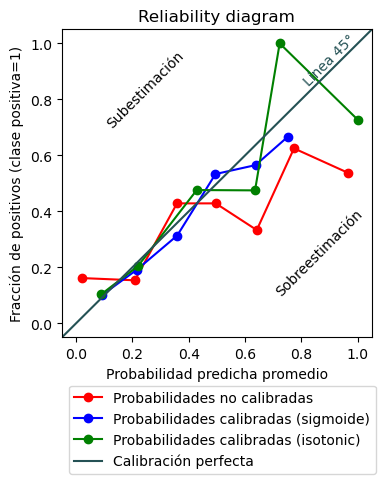

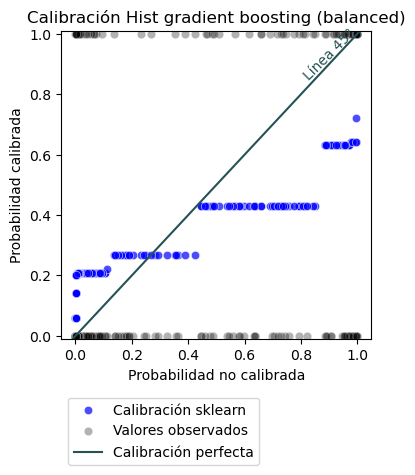

In [23]:
# | output: asis
for i in models_dict.keys():
    display(Markdown(f"## {i}"))

    pipe_sigmoid, pipe_isotonic, preds = calibrate_model(
        pipe=models_dict.get(i), 
        X_valid=X_valid, y_valid=y_valid, 
        X_test=X_test, y_test=y_test,
        cal_sigmoid=True,
        cal_isotonic=True,
        model_name=i
    )
    plt.show()

    plot_calibration(preds=preds, y_pred_prob_calibrated='pred_isotonic', model_name=i)
    plt.show()

    display(Markdown(f" "))

:::
:::
:::


::: {style="font-size: 50%;"}
## Tabla de calibración
::: {.nav-pills}
::: {.panel-tabset}

In [24]:
# | output: asis
for i in models_dict.keys():
    display(Markdown(f"## {i}"))
    _, _, preds = calibrate_model(
        pipe=models_dict.get(i), 
        X_valid=X_valid, y_valid=y_valid, 
        X_test=X_test, y_test=y_test,
        cal_sigmoid=True,
        cal_isotonic=True,
        model_name=i,
        plot_cal=False
    )
    display(Markdown('Modelo no calibrado'))
    calibration_table(preds=preds, bins=5, title='Modelo no calibrado')
    display(Markdown('Modelo calibrado (sigmoide)'))
    calibration_table(preds=preds, pred_column='pred_sigmoid', bins=5, title='Modelo calibrado (sigmoide)')
    display(Markdown(f" "))

## Hist gradient boosting

Modelo no calibrado

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(-0.10%, 0.12%]",50,4,0.00%,8.00%,8.00%
"(0.12%, 1.75%]",50,7,1.00%,14.00%,13.00%
"(1.75%, 22.80%]",50,14,8.00%,28.00%,20.00%
"(22.80%, 83.70%]",50,20,51.00%,40.00%,11.00%
"(83.70%, 100.00%]",50,30,95.00%,60.00%,35.00%


Modelo calibrado (sigmoide)

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(1.20%, 14.10%]",50,4,9.00%,8.00%,1.00%
"(14.10%, 22.80%]",50,7,18.00%,14.00%,4.00%
"(22.80%, 35.00%]",50,14,28.00%,28.00%,0.00%
"(35.00%, 49.90%]",50,20,41.00%,40.00%,1.00%
"(49.90%, 80.70%]",50,30,60.00%,60.00%,0.00%


## Decision tree

Modelo no calibrado

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(-0.10%, 100.00%]",250,75,29.00%,30.00%,1.00%


Modelo calibrado (sigmoide)

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(18.80%, 52.00%]",250,75,28.00%,30.00%,2.00%


## Logistc regression

Modelo no calibrado

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(2.99%, 11.90%]",50,4,8.00%,8.00%,0.00%
"(11.90%, 19.60%]",50,11,15.00%,22.00%,7.00%
"(19.60%, 35.60%]",50,12,28.00%,24.00%,4.00%
"(35.60%, 53.40%]",50,16,44.00%,32.00%,12.00%
"(53.40%, 85.20%]",50,32,62.00%,64.00%,2.00%


Modelo calibrado (sigmoide)

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(1.89%, 9.55%]",50,4,6.00%,8.00%,2.00%
"(9.55%, 17.20%]",50,11,13.00%,22.00%,9.00%
"(17.20%, 34.70%]",50,12,26.00%,24.00%,2.00%
"(34.70%, 55.10%]",50,16,44.00%,32.00%,12.00%
"(55.10%, 88.60%]",50,32,65.00%,64.00%,1.00%


## SVC

Modelo no calibrado

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(17.70%, 22.20%]",50,6,21.00%,12.00%,9.00%
"(22.20%, 24.30%]",50,9,23.00%,18.00%,5.00%
"(24.30%, 29.30%]",50,12,26.00%,24.00%,2.00%
"(29.30%, 41.00%]",50,20,35.00%,40.00%,5.00%
"(41.00%, 71.80%]",50,28,52.00%,56.00%,4.00%


Modelo calibrado (sigmoide)

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(11.50%, 17.00%]",50,6,15.00%,12.00%,3.00%
"(17.00%, 19.70%]",50,9,18.00%,18.00%,0.00%
"(19.70%, 26.80%]",50,12,23.00%,24.00%,1.00%
"(26.80%, 45.10%]",50,20,35.00%,40.00%,5.00%
"(45.10%, 86.30%]",50,28,61.00%,56.00%,5.00%


## Logistc regression (balanced)

Modelo no calibrado

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(6.52%, 23.40%]",50,4,17.00%,8.00%,9.00%
"(23.40%, 35.90%]",50,10,29.00%,20.00%,9.00%
"(35.90%, 56.80%]",50,13,47.00%,26.00%,21.00%
"(56.80%, 72.10%]",50,17,64.00%,34.00%,30.00%
"(72.10%, 92.70%]",50,31,79.00%,62.00%,17.00%


Modelo calibrado (sigmoide)

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(1.62%, 8.92%]",50,4,6.00%,8.00%,2.00%
"(8.92%, 16.70%]",50,10,12.00%,20.00%,8.00%
"(16.70%, 35.40%]",50,13,26.00%,26.00%,0.00%
"(35.40%, 54.90%]",50,17,44.00%,34.00%,10.00%
"(54.90%, 88.80%]",50,31,66.00%,62.00%,4.00%


## Hist gradient boosting (balanced)

Modelo no calibrado

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(-0.10%, 0.14%]",50,5,0.00%,10.00%,10.00%
"(0.14%, 2.85%]",50,8,1.00%,16.00%,15.00%
"(2.85%, 30.70%]",50,11,11.00%,22.00%,11.00%
"(30.70%, 88.80%]",50,24,62.00%,48.00%,14.00%
"(88.80%, 100.00%]",50,27,97.00%,54.00%,43.00%


Modelo calibrado (sigmoide)

/Users/karinabartolome/Documents/GitHub/workshops/01_ml/01_clasificacion/01_calibracion/custom_functions.py:216: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds.groupby("Bin", as_index=False)


Bin,N,N Clase 1,Probabilidadpromedio,% Clase 1(observado),Diferencia |avg prob - % clase 1|
"(1.34%, 14.40%]",50,5,9.00%,10.00%,1.00%
"(14.40%, 23.80%]",50,8,19.00%,16.00%,3.00%
"(23.80%, 35.10%]",50,11,29.00%,22.00%,7.00%
"(35.10%, 49.30%]",50,24,42.00%,48.00%,6.00%
"(49.30%, 80.20%]",50,27,59.00%,54.00%,5.00%


:::
:::
:::


::: {style="font-size: 50%;"}
## Comparativa de métricas

In [25]:
metrics_df_sigmoid = pd.DataFrame()
metrics_df_isotonic = pd.DataFrame()
preds_dict = {}
for i in models_dict.keys():
    pipe = models_dict.get(i)
    _, _, preds = calibrate_model(
        pipe=models_dict.get(i), 
        X_valid=X_valid, y_valid=y_valid, 
        X_test=X_test, y_test=y_test,
        cal_sigmoid=True,
        cal_isotonic=True,
        model_name=i,
        plot_cal=False
    )
   
    m = calculate_clf_metrics(
        preds['y_obs'], preds['pred_class_sigmoid'], preds['pred_sigmoid'], 
        name=i
    ).reset_index().rename({'index':'Modelo'},axis=1)
    metrics_df_sigmoid = pd.concat([metrics_df_sigmoid, m], axis=0)

    m = calculate_clf_metrics(
        preds['y_obs'], preds['pred_class_sigmoid'], preds['pred_isotonic'], 
        name=i
    ).reset_index().rename({'index':'Modelo'},axis=1)
    metrics_df_isotonic = pd.concat([metrics_df_isotonic, m], axis=0)

::: {.nav-pills}
::: {.panel-tabset}

In [26]:
# | output: asis
metrics_dfs = {
    'Modelo no calibrado': metrics_df,
    'Calibración sigmoide': metrics_df_sigmoid,
    'Calibración isotónica': metrics_df_isotonic
}
for i in metrics_dfs.keys():
    display(Markdown(f"## {i}"))
    display(GT(metrics_dfs.get(i).round(2))
        .data_color(
            columns=['Accuracy','Precision','Recall','F1','ROC AUC'],
            palette=[color_verde_claro, color_verde]
        )
        .data_color(
            columns=['Log Loss','Brier Loss'], palette=['white', 'red']
        )
    )
    display(Markdown(f" "))

## Modelo no calibrado

Modelo,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss,Brier Loss
Hist gradient boosting,0.72,0.53,0.53,0.53,0.74,0.93,0.22
Decision tree,0.69,0.49,0.47,0.48,0.63,11.1,0.31
Logistc regression,0.74,0.59,0.45,0.51,0.75,0.53,0.18
SVC,0.73,0.6,0.33,0.43,0.72,0.55,0.19
Logistc regression (balanced),0.64,0.44,0.69,0.54,0.75,0.6,0.21
Hist gradient boosting (balanced),0.71,0.52,0.59,0.55,0.74,0.98,0.23


## Calibración sigmoide

Modelo,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss,Brier Loss
Hist gradient boosting,0.74,0.61,0.4,0.48,0.74,0.53,0.18
Decision tree,0.69,0.49,0.47,0.48,0.63,0.58,0.2
Logistc regression,0.74,0.58,0.45,0.51,0.75,0.53,0.18
SVC,0.73,0.6,0.33,0.43,0.72,0.55,0.18
Logistc regression (balanced),0.75,0.6,0.47,0.53,0.75,0.53,0.17
Hist gradient boosting (balanced),0.72,0.55,0.35,0.43,0.74,0.54,0.18


## Calibración isotónica

Modelo,Accuracy,Precision,Recall,F1,ROC AUC,Log Loss,Brier Loss
Hist gradient boosting,0.74,0.61,0.4,0.48,0.73,0.95,0.18
Decision tree,0.69,0.49,0.47,0.48,0.63,0.58,0.2
Logistc regression,0.74,0.58,0.45,0.51,0.75,1.24,0.2
SVC,0.73,0.6,0.33,0.43,0.7,0.84,0.19
Logistc regression (balanced),0.75,0.6,0.47,0.53,0.75,1.22,0.19
Hist gradient boosting (balanced),0.72,0.55,0.35,0.43,0.73,1.09,0.19


:::
:::
:::


# Comentarios finales

::: {style="font-size: 50%;"}
## Comentarios finales

Se busca un modelo en donde la probabilidad promedio de cada bin se corresponda con el % de clase positiva observado en ese bin según las predicciones del modelo.

Esto es útil para la toma de decisiones, ya que permite establecer punto de cortes diferenciales en función de la aversión en riesgo de la entidad.

Por ejemplo:

- En un modelo de scoring crediticio, otorgarle créditos a N individuos con probabilidad en cierto intervalo tiene un riesgo asociado (mora esperada)
- En un modelo de churn (abandono) de clientes, otorgarle una promoción a individuos de cierto intervalo de probabilidad de abandono tiene un costo asociado (descuento para individuos que no abandonarían)
- Entre otros.

:::

::: {style="font-size: 50%;"}
## Referencias / Recursos

[Probability Calibration Workshop - PyData 2020](https://www.youtube.com/watch?v=A1NGGV3Z4m4&list=PLeVfk5xTWHYBw22D52etymvcpxey4QFIk&ab_channel=numeristical)

:::


## Contacto

{{< fa brands linkedin size=1x >}} [karinabartolome](https://www.linkedin.com/in/karinabartolome/)

{{< fa brands twitter size=1x >}} [@karbartolome](https://twitter.com/karbartolome)

{{< fa brands github size=1x >}} [@karbartolome](http://github.com/karbartolome)

{{< fa link >}} [Blog](https://karbartolome-blog.netlify.com)
